In [1]:
import pandas as pd
corpus = pd.read_csv("corpus_JHE0.csv")
#print(corpus['text'][0])
print(corpus.shape)
n = corpus.shape[0]
print(n)

(4014, 14)
4014


In [50]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

for x in range(n):
    sen = sia.polarity_scores(corpus.text.values[x])
    df = pd.DataFrame([sen])
    df['eid'] = corpus.eid.values[x]
    df['pii'] = corpus.pii.values[x]

    if x==0:
        sen_all = df
    else:
        frames = [sen_all, df]
        sen_all = pd.concat(frames)

sen_all.to_csv('sentiments.csv',index=False)

In [8]:
# Function to print top words of LDA ()
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# Storing the entire training text in a list
text = list(corpus.text.values)

tf_vectorizer = CountVectorizer(max_df=0.5, min_df=0.05)


# tokenize and build vocab
tf_vectorizer.fit(text)

#print(tf_vectorizer.vocabulary_)

# encode document
tf = tf_vectorizer.transform(text)
# summarize encoded vector
#print(tf.shape)
#print(tf.toarray())

#tf

In [3]:
import numpy as np
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [4]:
# Other imports
#from collections import Counter
#from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
#from matplotlib import pyplot as plt
#%matplotlib inline
#import base64
import numpy as np
import pandas as pd

lda_model = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 1981)

In [5]:
lda_model.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=1981)

In [6]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tf))
# See model parameters
print(lda_model.get_params())

Log Likelihood:  -65584333.80348561
Perplexity:  1598.938876935933
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 1981, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [9]:
n_top_words = 30
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_model, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:neandertal neanderthal sapiens trinkaus spain shape european arsuaga europe atapuerca stringer canal castro hublin cranial los rib anthropol rosa paleolithic del bermufadez erectus smith de paris sima lateral hominins krapina

Topic #1:habitat formation fauna basin east locality isotope kenya climate plant lake bed miocene forest member tuff vegetation pliocene hominin leakey isotopic diet taxon water eastern van southern valley northern open

Topic #2:man genetic rate american gene chromosome dna frequency sequence physical growth selection biological genetics distance ancient blood language trait cell child disease acid must series protein society australian indian sex

Topic #3:mass limb ruff estimate femur femoral muscle locomotion walking force growth joint dimorphism male adult head locomotor phys female anthropol proportion gait chimpanzee bipedal equation skeletal stature regression foot pelvis

Topic #4:australopithecus erectus afarensis crania

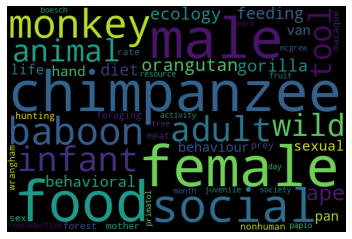

In [87]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic

# most important words for each topic
vocab = tf_feature_names

def draw_word_cloud(index):
    imp_words_topic=""
    comp=lda_model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

draw_word_cloud(9)


In [89]:
#print maximum topic of a document
doc_topic = lda_model.transform(tf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    #print("doc: {} topic: {}\n".format(n,topic_most_pr))

In [99]:
n = tf.shape[0]
print(n)
# Create Document — Topic Matrix
lda_output = lda_model.transform(tf)
print(lda_output.shape)
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(n)]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
df_document_topic["eid"] = corpus.eid.values
df_document_topic["pii"] = corpus.pii.values
df_document_topic.to_csv('dominant_topics.csv',index=False)

4014
(4014, 10)


In [101]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
df_topic_keywords.to_csv('topics_keywords.csv',index=True)
print(df_topic_keywords.shape)

(10, 4102)
